In [1]:
import tensorflow as tf
from keras import models
from keras import layers
import os
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

### This is a binary classification model issue, so in the last layer I added one neuron with a sigmoid activation function.
####The `tf.distribute.Strategy` API which implemented below, provides an abstraction for distributing your training across multiple processing units. It allows you to carry out distributed training using existing models and training code with minimal changes.

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [4]:
with strategy.scope():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = optimizers.RMSprop(learning_rate=1e-4), metrics = ['acc'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Upload your folders of train and validation images in colab

In [6]:
!unzip /content/train.zip

Archive:  /content/train.zip
   creating: train/
   creating: train/cats/
  inflating: train/cats/cat0.jpg     
  inflating: train/cats/cat1.jpg     
  inflating: train/cats/cat10.jpg    
  inflating: train/cats/cat100.jpg   
  inflating: train/cats/cat101.jpg   
  inflating: train/cats/cat102.jpg   
  inflating: train/cats/cat103.jpg   
  inflating: train/cats/cat104.jpg   
  inflating: train/cats/cat105.jpg   
  inflating: train/cats/cat106.jpg   
  inflating: train/cats/cat107.jpg   
  inflating: train/cats/cat108.jpg   
  inflating: train/cats/cat109.jpg   
  inflating: train/cats/cat11.jpg    
  inflating: train/cats/cat110.jpg   
  inflating: train/cats/cat111.jpg   
  inflating: train/cats/cat112.jpg   
  inflating: train/cats/cat113.jpg   
  inflating: train/cats/cat114.jpg   
  inflating: train/cats/cat115.jpg   
  inflating: train/cats/cat116.jpg   
  inflating: train/cats/cat117.jpg   
  inflating: train/cats/cat118.jpg   
  inflating: train/cats/cat119.jpg   
  inflating: t

In [7]:
!unzip /content/validation.zip

Archive:  /content/validation.zip
   creating: validation/
   creating: validation/cats/
  inflating: validation/cats/cat1000.jpg  
  inflating: validation/cats/cat1001.jpg  
  inflating: validation/cats/cat1002.jpg  
  inflating: validation/cats/cat1003.jpg  
  inflating: validation/cats/cat1004.jpg  
  inflating: validation/cats/cat1005.jpg  
  inflating: validation/cats/cat1006.jpg  
  inflating: validation/cats/cat1007.jpg  
  inflating: validation/cats/cat1008.jpg  
  inflating: validation/cats/cat1009.jpg  
  inflating: validation/cats/cat1010.jpg  
  inflating: validation/cats/cat1011.jpg  
  inflating: validation/cats/cat1012.jpg  
  inflating: validation/cats/cat1013.jpg  
  inflating: validation/cats/cat1014.jpg  
  inflating: validation/cats/cat1015.jpg  
  inflating: validation/cats/cat1016.jpg  
  inflating: validation/cats/cat1017.jpg  
  inflating: validation/cats/cat1018.jpg  
  inflating: validation/cats/cat1019.jpg  
  inflating: validation/cats/cat1020.jpg  
  inflat

In [16]:
BUFFER_SIZE = 10
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_directory("/content/train", target_size=(150, 150), batch_size=BATCH_SIZE, class_mode='binary', shuffle=BUFFER_SIZE)
validation_generator = test_datagen.flow_from_directory("/content/validation", target_size=(150, 150), batch_size=BATCH_SIZE, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (64, 150, 150, 3)
labels batch shape: (64,)


### Define the checkpoint directory to store the checkpoints and define the name of the checkpoint files.

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

### Define a function for decaying the learning rate and you can define any decay function you need.

In [20]:
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

### Define a callback for printing the learning rate at the end of each epoch.

In [21]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))

### Put all the callbacks together.

In [22]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [26]:
memoryM = model.fit_generator(train_generator, steps_per_epoch=int(2000/BATCH_SIZE), epochs=30, validation_data=validation_generator, validation_steps=int(1000/BATCH_SIZE), callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 0.7224 - acc: 0.5630
Learning rate for epoch 1 is 0.0010000000474974513
31/31 [==============================] - 9s 299ms/step - loss: 0.7224 - acc: 0.5630 - val_loss: 0.6750 - val_acc: 0.6094 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 0.6609 - acc: 0.6178
Learning rate for epoch 2 is 0.0010000000474974513
31/31 [==============================] - 11s 368ms/step - loss: 0.6609 - acc: 0.6178 - val_loss: 0.6517 - val_acc: 0.6104 - lr: 0.0010
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 0.6254 - acc: 0.6513
Learning rate for epoch 3 is 0.0010000000474974513
31/31 [==============================] - 11s 366ms/step - loss: 0.6254 - acc: 0.6513 - val_loss: 0.5672 - val_acc: 0.7010 - lr: 0.0010
Epoch 4/30
31/31 [==============================] - ETA: 0s - loss: 0.5242 - acc: 0.7386
Learning rate for epoch 4 is 9.999999747378752e-05
31/31 [=============================

### Let's plot the history of our memoryM model

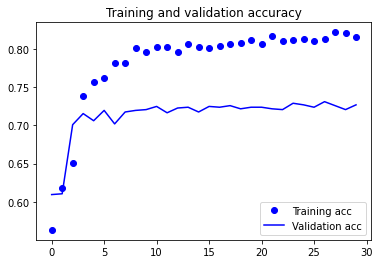

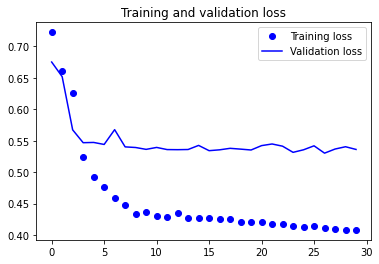

In [27]:
import matplotlib.pyplot as plt
acc = memoryM.history['acc']
val_acc = memoryM.history['val_acc']
loss = memoryM.history['loss']
val_loss = memoryM.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### What should we do with this huge overfit?